# Robot Evolution: Random vs Smart Agent

Simple visualization showing how robot behavior evolves from random to intelligent.


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import importlib.util

# Import the environment
spec = importlib.util.spec_from_file_location("robot_env", "01_robot_warehouse_env.py")
robot_env = importlib.util.module_from_spec(spec)
spec.loader.exec_module(robot_env)
OrderPickingEnv = robot_env.OrderPickingEnv

# USER CONTROLS
GRID_SIZE = (5, 6)          # Warehouse size
MAX_STEPS = 100              # Steps to show per agent


In [16]:
class RandomAgent:
    """Completely random agent"""
    def choose_action(self, state):
        return np.random.randint(0, 4)

class HeuristicAgent:
    """Heuristic agent with obstacle avoidance"""
    def __init__(self):
        self.last_pos = None
        self.stuck_counter = 0
        
    def choose_action(self, state):
        robot_pos = np.array(state['robot_pos'])
        
        # Check if stuck (same position for multiple steps)
        if self.last_pos is not None and np.array_equal(robot_pos, self.last_pos):
            self.stuck_counter += 1
        else:
            self.stuck_counter = 0
        self.last_pos = robot_pos.copy()
        
        # If stuck for too long, try random moves to get unstuck
        if self.stuck_counter > 3:
            return np.random.randint(0, 4)
        
        # Determine target
        if state['all_items_collected_phase']:
            target = np.array([0, 0])  # depot
        else:
            # Find nearest unpicked item
            unpicked_items = []
            for i, picked in enumerate(state['items_picked']):
                if not picked:
                    unpicked_items.append(i)
            
            if unpicked_items:
                distances = []
                for item_idx in unpicked_items:
                    item_pos = np.array(self.env.item_locations[item_idx])
                    dist = abs(robot_pos[0] - item_pos[0]) + abs(robot_pos[1] - item_pos[1])
                    distances.append((dist, item_pos))
                target = min(distances)[1]
            else:
                target = np.array([0, 0])  # depot
        
        # Calculate preferred directions toward target
        diff = target - robot_pos
        
        # Create priority list of actions toward target
        actions = []
        if diff[0] < 0:  # Need to go up
            actions.append(0)
        elif diff[0] > 0:  # Need to go down
            actions.append(1)
            
        if diff[1] < 0:  # Need to go left
            actions.append(2)
        elif diff[1] > 0:  # Need to go right
            actions.append(3)
        
        # Add remaining actions
        all_actions = [0, 1, 2, 3]
        for action in all_actions:
            if action not in actions:
                actions.append(action)
        
        # Try actions in order, check if move is valid
        for action in actions:
            if self._is_valid_move(robot_pos, action):
                return action
        
        # If no valid move toward target, try any valid move
        for action in all_actions:
            if self._is_valid_move(robot_pos, action):
                return action
                
        # Last resort - random action
        return np.random.randint(0, 4)
    
    def _is_valid_move(self, pos, action):
        """Check if move would hit wall or obstacle"""
        move_deltas = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right
        new_pos = pos + np.array(move_deltas[action])
        
        # Check boundaries
        if new_pos[0] < 0 or new_pos[0] >= self.env.grid_rows:
            return False
        if new_pos[1] < 0 or new_pos[1] >= self.env.grid_cols:
            return False
            
        # Check obstacles
        for obs in self.env.obstacle_locations:
            if np.array_equal(new_pos, obs):
                return False
                
        return True
    
    def set_env(self, env):
        self.env = env


In [17]:
def run_and_visualize_agent(agent, agent_name, env):
    """Run agent and return path and performance"""
    state = env.reset()
    agent.set_env(env) if hasattr(agent, 'set_env') else None
    
    path = [env.robot_pos.copy()]
    total_reward = 0
    
    for step in range(MAX_STEPS):
        action = agent.choose_action(state)
        state, reward, done, info = env.step(action)
        path.append(env.robot_pos.copy())
        total_reward += reward
        
        if done:
            break
    
    # Check success
    success = done and env.all_items_collected_phase and np.array_equal(env.robot_pos, env.depot_pos)
    items_collected = sum(env.items_picked_status)
    
    return {
        'path': np.array(path),
        'reward': total_reward,
        'steps': len(path) - 1,
        'success': success,
        'items_collected': items_collected,
        'final_state': state
    }

def visualize_comparison(env, results):
    """Create side-by-side comparison visualization"""
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    agents = ['Random Agent', 'Heuristic Agent'] 
    colors = ['red', 'blue']
    
    for i, (agent_name, result) in enumerate(zip(agents, results)):
        ax = axes[i]
        
        # Draw grid
        ax.set_xlim(-0.5, env.grid_cols - 0.5)
        ax.set_ylim(env.grid_rows - 0.5, -0.5)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        # Draw obstacles
        for obs in env.obstacle_locations:
            rect = patches.Rectangle((obs[1]-0.4, obs[0]-0.4), 0.8, 0.8,
                                   facecolor='gray', edgecolor='black')
            ax.add_patch(rect)
        
        # Draw depot
        ax.plot(env.depot_pos[1], env.depot_pos[0], 'H', markersize=12, 
                color='gold', markeredgecolor='black')
        
        # Draw items
        for j, item_pos in enumerate(env.item_locations):
            if env.items_picked_status[j]:
                ax.plot(item_pos[1], item_pos[0], 'X', markersize=10, color='lightcoral')
            else:
                ax.plot(item_pos[1], item_pos[0], 's', markersize=10, color='green')
        
        # Draw path
        path = result['path']
        ax.plot(path[:, 1], path[:, 0], '--', color=colors[i], alpha=0.7, linewidth=2)
        
        # Draw robot final position
        ax.plot(env.robot_pos[1], env.robot_pos[0], 'o', markersize=12, color=colors[i])
        
        # Title with performance
        status = "SUCCESS" if result['success'] else "INCOMPLETE"
        color = "green" if result['success'] else "red"
        ax.set_title(f"{agent_name}\\nSteps: {result['steps']}, Items: {result['items_collected']}/{len(env.item_locations)}\\nStatus: {status}", 
                    color=color, fontweight='bold')
    
    plt.tight_layout()
    plt.suptitle('🤖 Robot Evolution: Random vs Heuristic Behavior', fontsize=14, fontweight='bold', y=1.02)
    return fig


Environment: 5x6 grid
Items at: [array([2, 4]), array([4, 1]), array([1, 2])]
Obstacles at: [array([1, 3]), array([2, 1]), array([3, 4])]
Depot at: [0 0]
\n🎯 Running comparison...
Testing random agent...
Testing Heuristic agent...
\n📊 RESULTS:
Random Agent: 76 steps, 3 items, SUCCESS
Heuristic Agent: 16 steps, 3 items, SUCCESS


/opt/anaconda3/envs/helprl_paper/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


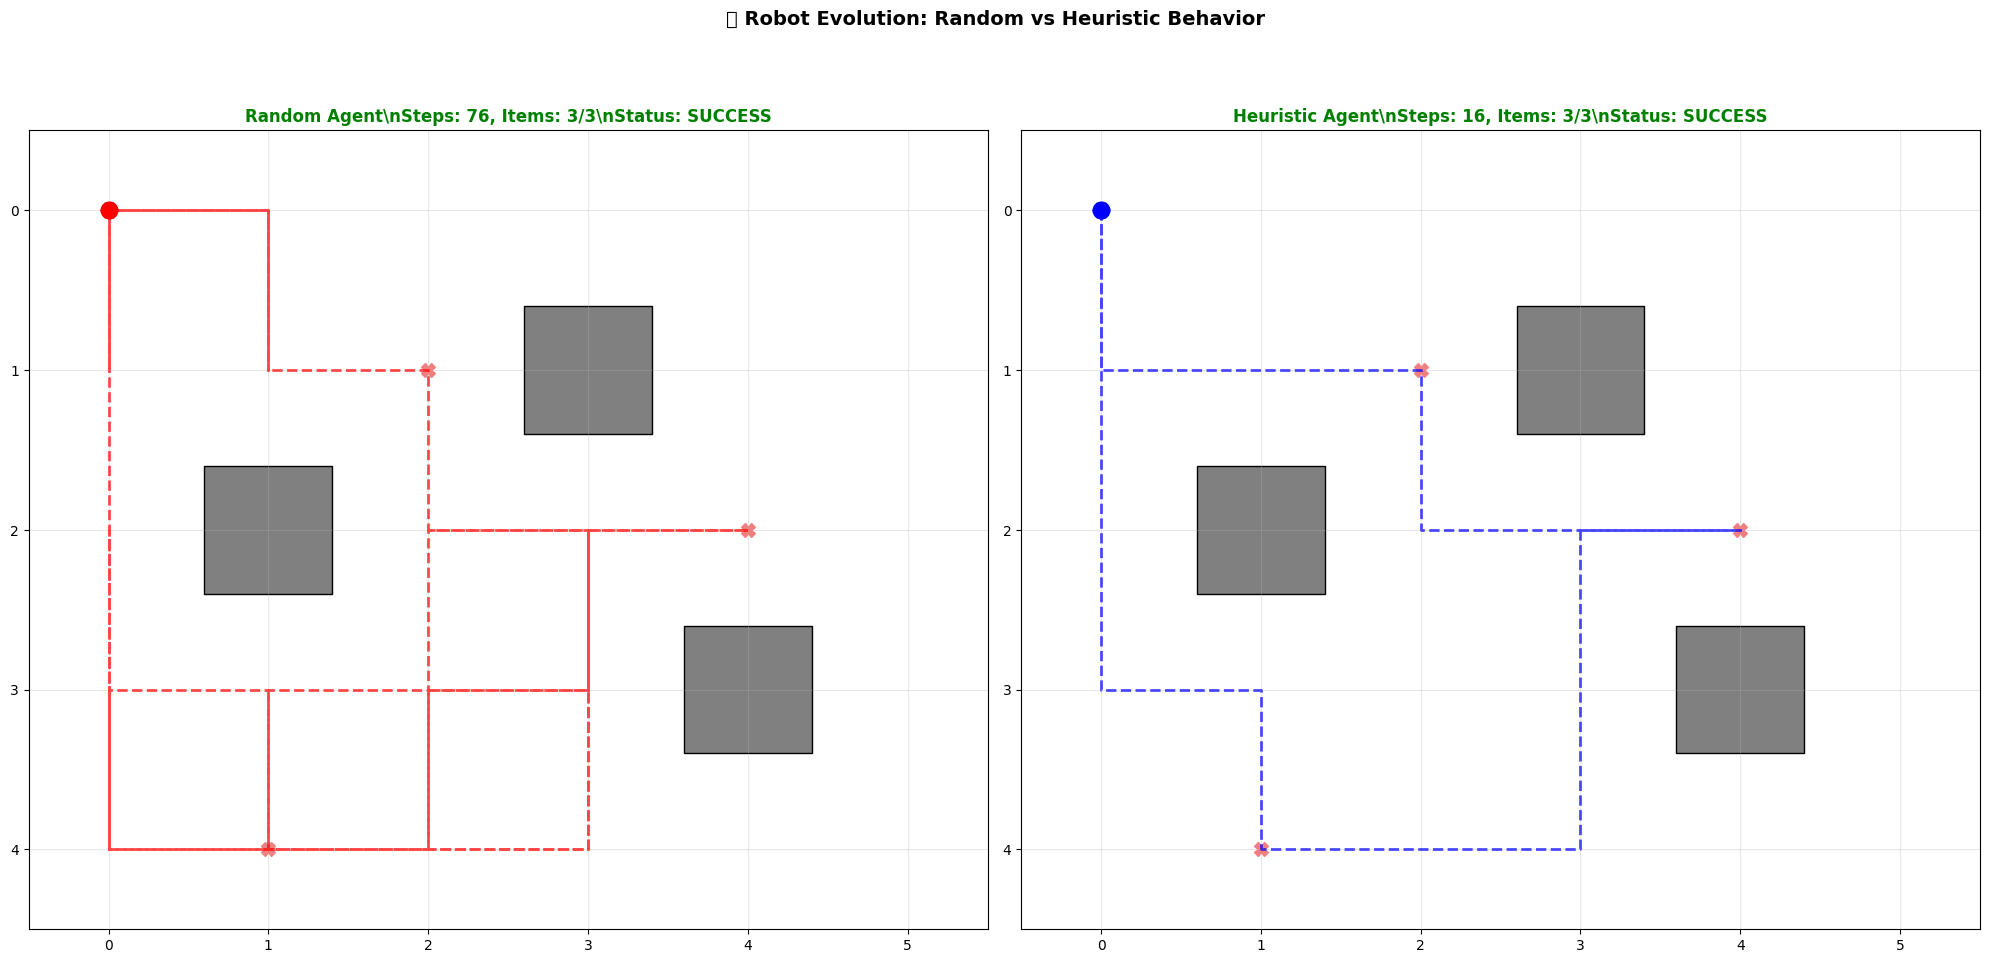

In [18]:
# 🏭 Create Environment
env = OrderPickingEnv(
    grid_size=GRID_SIZE,
    depot_pos=(0, 0),
    item_locations=[(2, 4), (4, 1), (1, 2)],  # Fixed positions for fair comparison
    obstacle_locations=[(1, 3), (2, 1), (3, 4)],
    max_steps_per_episode=MAX_STEPS
)

print(f"Environment: {GRID_SIZE[0]}x{GRID_SIZE[1]} grid")
print(f"Items at: {env.item_locations}")
print(f"Obstacles at: {env.obstacle_locations}")
print(f"Depot at: {env.depot_pos}")

# 🤖 Create Agents
random_agent = RandomAgent()
Heuristic_agent = HeuristicAgent()

print("\\n🎯 Running comparison...")

# Test both agents on same environment
results = []

# Random agent
print("Testing random agent...")
random_result = run_and_visualize_agent(random_agent, "Random", env)
results.append(random_result)

# Heuristic agent (reset environment first)
print("Testing Heuristic agent...")
Heuristic_result = run_and_visualize_agent(Heuristic_agent, "Heuristic", env)
results.append(Heuristic_result)

# Show results
print(f"\\n📊 RESULTS:")
print(f"Random Agent: {random_result['steps']} steps, {random_result['items_collected']} items, {'SUCCESS' if random_result['success'] else 'FAILED'}")
print(f"Heuristic Agent: {Heuristic_result['steps']} steps, {Heuristic_result['items_collected']} items, {'SUCCESS' if Heuristic_result['success'] else 'FAILED'}")

# Visualize
visualize_comparison(env, results)
plt.show()


\n🔄 Running multiple tests to show consistency...
\n📊 EVOLUTION SUMMARY (5 runs):
Random Agent: 0/5 success rate, avg 100.0 steps
Heuristic Agent:  5/5 success rate, avg 16.0 steps
\n🚀 Improvement: 100% better success rate!


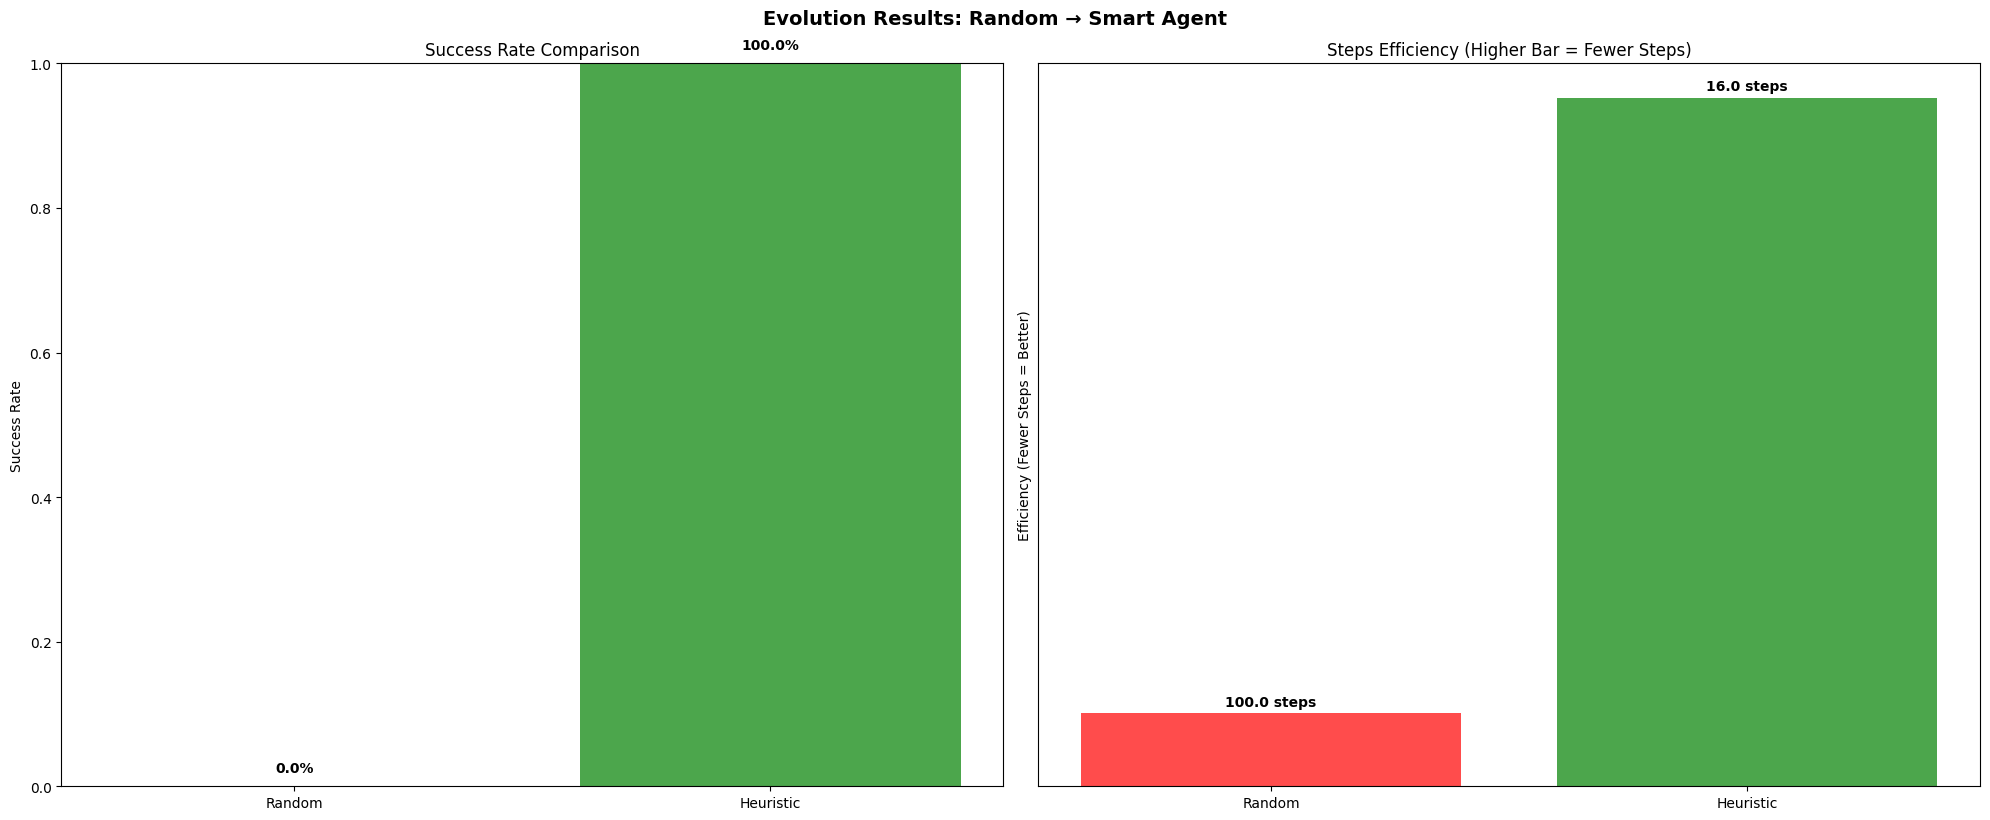

In [19]:
# 📈 Multiple Runs Comparison
print("\\n🔄 Running multiple tests to show consistency...")

random_successes = []
heuristic_successes = []
random_steps = []
heuristic_steps = []

for i in range(5):
    # Random agent
    random_result = run_and_visualize_agent(random_agent, "Random", env)
    random_successes.append(random_result['success'])
    random_steps.append(random_result['steps'])
    # Heuristic agent
    heuristic_result = run_and_visualize_agent(Heuristic_agent, "Heuristic", env)
    heuristic_successes.append(heuristic_result['success'])
    heuristic_steps.append(heuristic_result['steps'])

print(f"\\n📊 EVOLUTION SUMMARY (5 runs):")
print(f"Random Agent: {sum(random_successes)}/5 success rate, avg {np.mean(random_steps):.1f} steps")
print(f"Heuristic Agent:  {sum(heuristic_successes)}/5 success rate, avg {np.mean(heuristic_steps):.1f} steps")
print(f"\\n🚀 Improvement: {((sum(heuristic_successes) - sum(random_successes))/5*100):.0f}% better success rate!")

# Simple bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Success rates
agents = ['Random', 'Heuristic']
success_rates = [sum(random_successes)/5, sum(heuristic_successes)/5]
colors = ['red', 'green']
bars1 = ax1.bar(agents, success_rates, color=colors, alpha=0.7)
ax1.set_ylabel('Success Rate')
ax1.set_title('Success Rate Comparison')
ax1.set_ylim(0, 1)
for bar, rate in zip(bars1, success_rates):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{rate:.1%}', ha='center', fontweight='bold')

# Steps comparison (inverted bars - lower steps = taller bar)
avg_steps = [np.mean(random_steps), np.mean(heuristic_steps)]
# Invert steps so that fewer steps = higher bar (more intuitive)
max_steps_shown = max(avg_steps) + 10  # Add buffer for visualization
inverted_steps = [max_steps_shown - steps for steps in avg_steps]
bars2 = ax2.bar(agents, inverted_steps, color=colors, alpha=0.7)
ax2.set_ylabel('Efficiency (Fewer Steps = Better)')
ax2.set_title('Steps Efficiency (Higher Bar = Fewer Steps)')
# Show actual steps on the bars
for bar, steps in zip(bars2, avg_steps):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{steps:.1f} steps', ha='center', fontweight='bold')
# Remove y-axis ticks since they're now inverted and confusing
ax2.set_yticks([])

plt.tight_layout()
plt.suptitle('Evolution Results: Random → Smart Agent', fontsize=14, fontweight='bold', y=1.02)
plt.show()
